In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)
import numpy
import lsst.daf.persistence as daf_persistence
import lsst.afw.geom as afw_geom

In [2]:
def overlay_masks(exposure, bbox=None, sources=None):
    masked_image = exposure.getMaskedImage()
    if bbox is not None:
        masked_image = masked_image.Factory(masked_image, bbox)
    (img, mask, var) = masked_image.getArrays()
    plt.imshow(numpy.log10(img-2*img.min()), interpolation='nearest', cmap='gray')
    plt.imshow(mask, interpolation='nearest', cmap='Blues', alpha=0.3)
    if sources is not None:
        testbox = afw_geom.Box2D(bbox) # convert to a floating point box
        for source in sources:
            if testbox.contains(source.getCentroid()):
                # Need to account for difference in pixel indexing between matplotlib and stack
                plt.scatter(source.getX()-testbox.getMinX()-0.5, source.getY()-testbox.getMinY()-0.5, 
                            marker='+', c='r', alpha=0.5)
    plt.show()

In [3]:
!if ! [ -d singlechip_sample ]; then curl -O https://lsst-web.ncsa.illinois.edu/~krughoff/data/singlechip.tar.gz ; tar zxvf singlechip.tar.gz; fi

In [4]:
butler = daf_persistence.Butler('singlechip_sample')
exp = butler.get('calexp', visit=410877, ccd=28, filter='r')

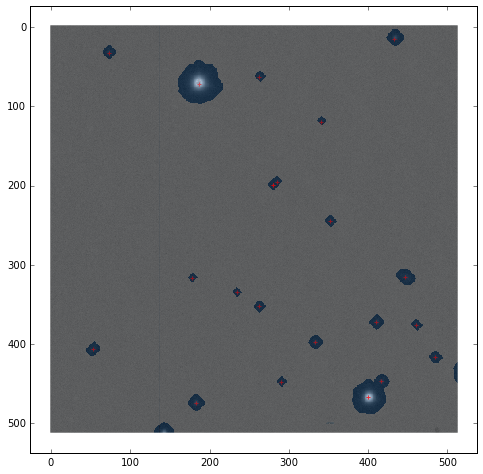

In [5]:
import lsst.afw.geom as afw_geom
bbox = afw_geom.Box2I(afw_geom.Point2I(1024, 1024), afw_geom.Extent2I(512,512))
sources = butler.get('src', visit=410877, ccd=28, filter='r')
overlay_masks(exp, bbox=bbox, sources=sources)

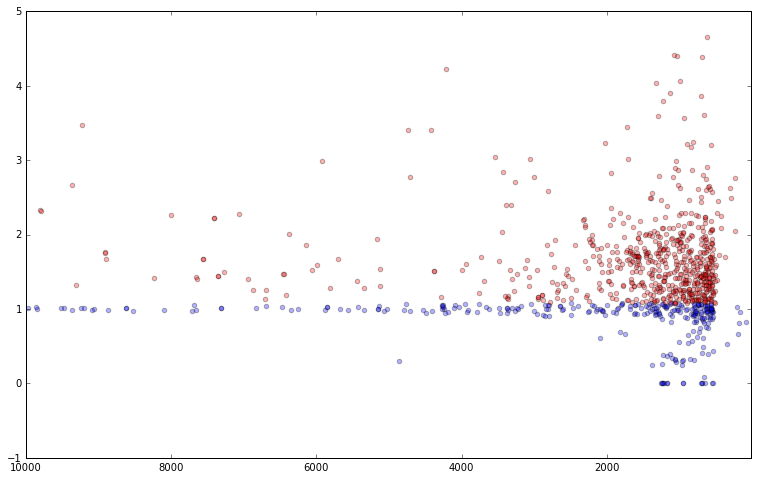

In [6]:
x = sources.getPsfFlux()
y = sources.getModelFlux()/sources.getPsfFlux()
extend = sources.get('base_ClassificationExtendedness_value')
x = numpy.array(x)
y = numpy.array(y)
stars = numpy.where(extend==0.0)[0]
galaxies = numpy.where(extend>0.)[0]
plt.scatter(x[stars], y[stars], alpha=0.3)
plt.scatter(x[galaxies], y[galaxies], c='r', alpha=0.3)
plt.xlim(10000, 10)
plt.ylim(-1, 5)
plt.show()